# 使用分析器优化TensorFlow性能

使用分析器提供的工具来跟踪TensorFlow模型的性能。看看你的模型在主机(CPU)，设备(GPU)，或者在主机和设备的组合上是如何运行的。

分析可以帮助您了解模型中各种TensorFlow操作(ops)的硬件资源消耗(时间和内存)，并解决性能瓶颈，最终使模型执行得更快。

本指南将指导您如何安装分析器、各种可用工具、分析器收集性能数据的不同模式，以及一些优化模型性能的推荐最佳实践。

如果您想分析您的模型在Cloud TPUs上的性能，请参考Cloud TPUs指南。

注意:您不能使用分析器来获得tf.data可用的 tf.data.experimental.service 的配置文件

## 安装分析器和GPU的前期准备工作

通过从GitHub存储库中下载并运行install_and_run.py脚本来安装分析器。

要在GPU上配置文件，你必须:

1.满足在TensorFlow GPU支持软件要求中列出的NVIDIA®GPU驱动程序和CUDA®工具包的要求。

2.确保路径上存在CUPTI:

In [ ]:
/sbin/ldconfig -N -v $(sed 's/:/ /g' <<< $LD_LIBRARY_PATH) | \
grep libcupti

如果路径上没有CUPTI，可以通过运行以下命令将其安装目录前置到$LD_LIBRARY_PATH环境变量:

In [ ]:
export LD_LIBRARY_PATH=/usr/local/cuda/extras/CUPTI/lib64:$LD_LIBRARY_PATH

再次运行上面的ldconfig命令来验证是否找到了CUPTI库。

### 解决权限问题

当您在Docker环境或Linux上使用CUDA®Toolkit运行profiling时，您可能会遇到与CUPTI权限不足相关的问题(CUPTI_ERROR_INSUFFICIENT_PRIVILEGES)。查看NVIDIA开发人员文档，了解如何在Linux上解决这些问题的更多信息。

要解决Docker环境中的CUPTI权限问题，请运行

In [ ]:
docker run option '--privileged=true'

## 分析器工具

只有在获取了一些模型数据后，在TensorBoard中的Profile选项卡中才会出现Profiler。

注意:分析器需要internet访问才能加载谷歌图表库。如果您在本地机器、公司防火墙后或数据中心完全脱机运行TensorBoard，可能会丢失一些图表和表格。

分析器有一些工具可以帮助进行性能分析:



概述页面

输入管道分析器

TensorFlow统计数据

跟踪查看器

GPU内核数据

内存配置文件工具

Pod查看器



### 概述页面

“概述”页面提供了概要文件运行期间模型执行情况的顶级视图。该页面显示了主机和所有设备的汇总概述页面，以及一些提高模型培训性能的建议。也可以在“主机”下拉列表中选择单个主机。



“概述”页面显示的数据如下：

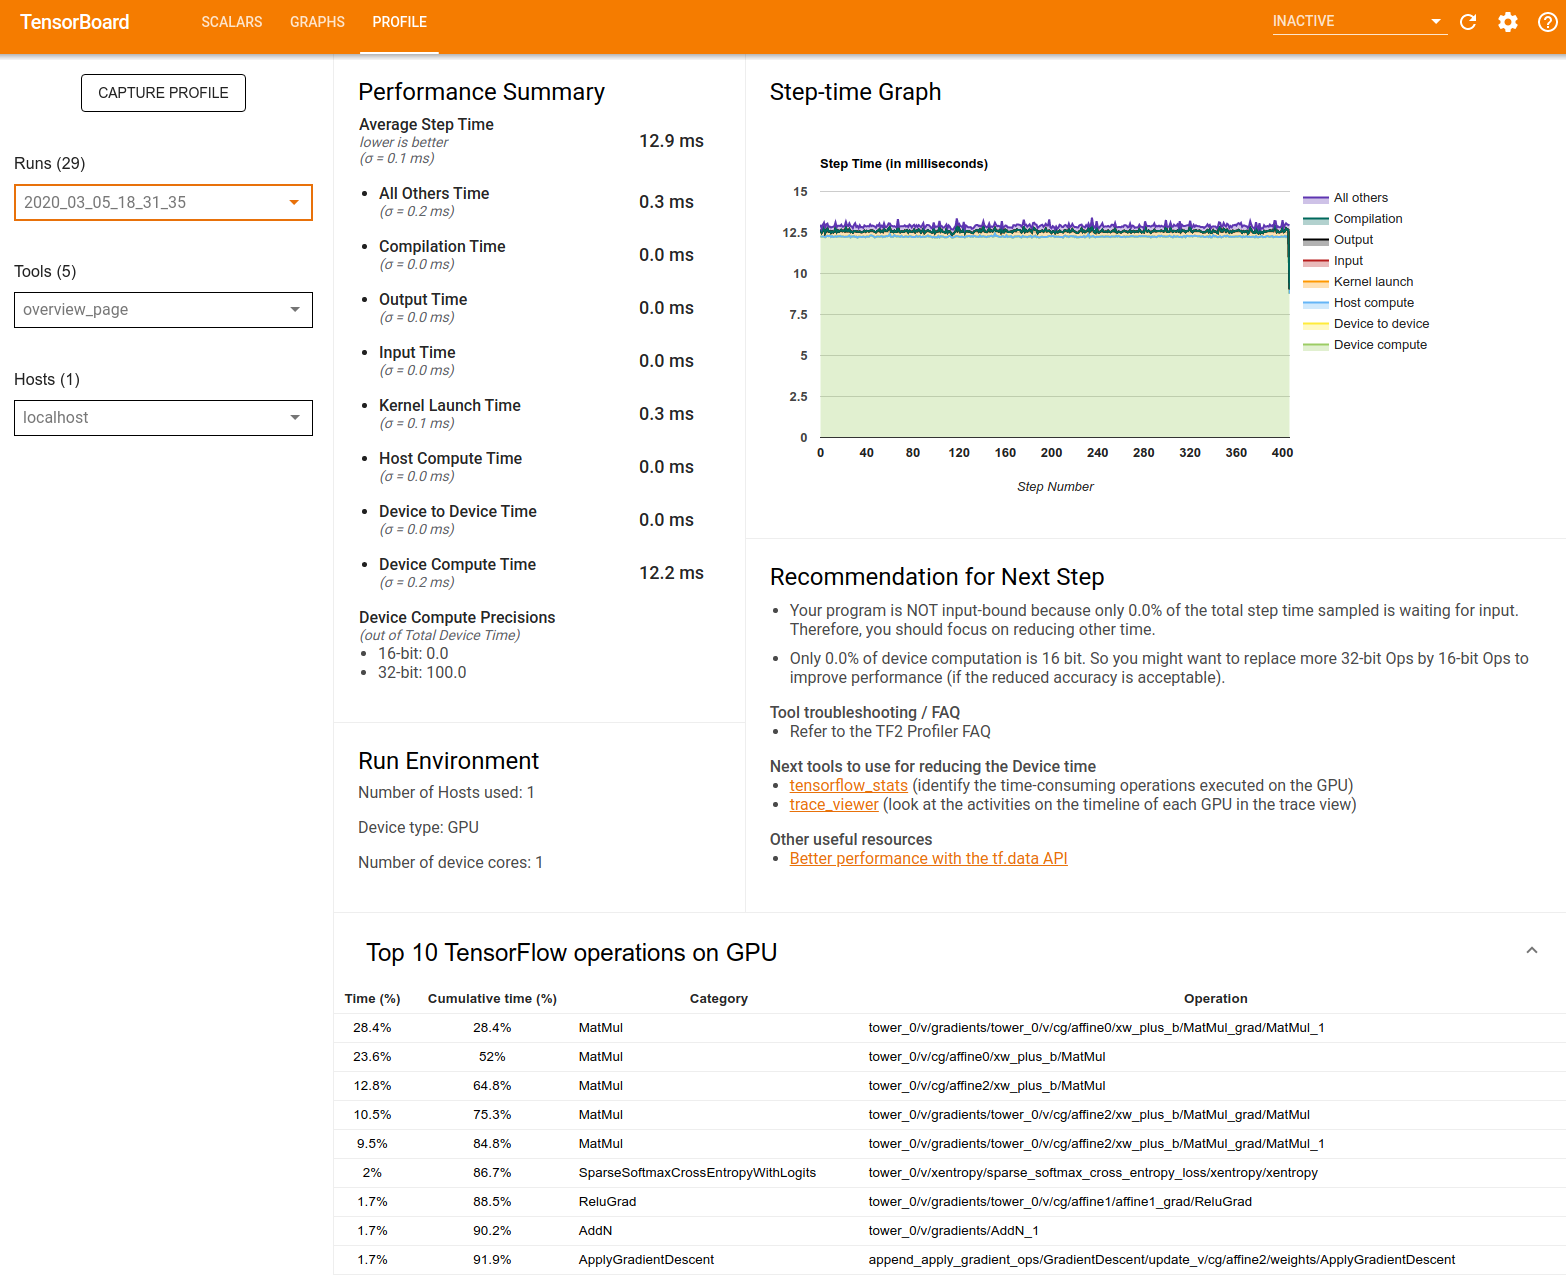

性能摘要-显示模型性能的高级摘要。绩效总结包括两部分：

1.Step-time分解---将平均步骤时间分为多个类别：

   Compilation-编译内核所花费的时间
   
   Input—读取输入数据所用的时间
   
   Output—读取输出数据所用的时间
   
   Kernel launch-主机启动内核所花费的时间
   
   主机计算时间

   设备间通信时间

   设备上的计算时间

   所有其他的，包括Python开销

2.设备计算精度-报告使用16位和32位计算的设备计算时间百分比

Step-time图-显示所有采样步骤的设备step time（以毫秒为单位）的图形。每一步都被分为多个类别（用不同的颜色）来划分时间。红色区域对应于设备空闲等待来自主机的输入数据的部分时间。绿色区域显示设备实际工作的时间

设备上的前10个TensorFlow操作-显示设备上运行时间最长的操作。



每一行显示一个操作的自身时间（作为所有操作占用时间的百分比）、累计时间、类别和名称。

运行环境-显示模型运行环境的高级摘要，包括：



使用的主机数

设备类型（GPU/TPU）

设备核心数

下一步建议—报告模型何时被输入绑定，并推荐可用于定位和解决模型性能瓶颈的工具

### 输入管道分析器

当一个TensorFlow程序从文件中读取数据时，它以流水线的方式从TensorFlow图的顶部开始。读取过程被分成多个数据处理阶段，这些数据处理阶段串联在一起，其中一个阶段的输出是下一个阶段的输入。这种读取数据的系统称为输入管道。

从文件中读取记录的典型管道有以下几个阶段:

1.文件读取

2.文件预处理(可选)

3.文件从主机传输到设备

低效的输入管道会严重降低应用程序的速度。当应用程序在输入管道中花费大量时间时，它就被认为是输入受限的。使用从输入管道分析器获得的结果来理解输入管道的低效之处。

输入管道分析器立即告诉您您的程序是否有输入限制，并引导您通过设备和主机端分析，以调试输入管道中的任何阶段的性能瓶颈。

有关优化数据输入管道的最佳实践，请参阅输入管道性能指南。

#### 输入管道仪表盘

要打开输入管道分析器，请选择Profile，然后从Tools下拉菜单中选择input_pipeline_analyzer。

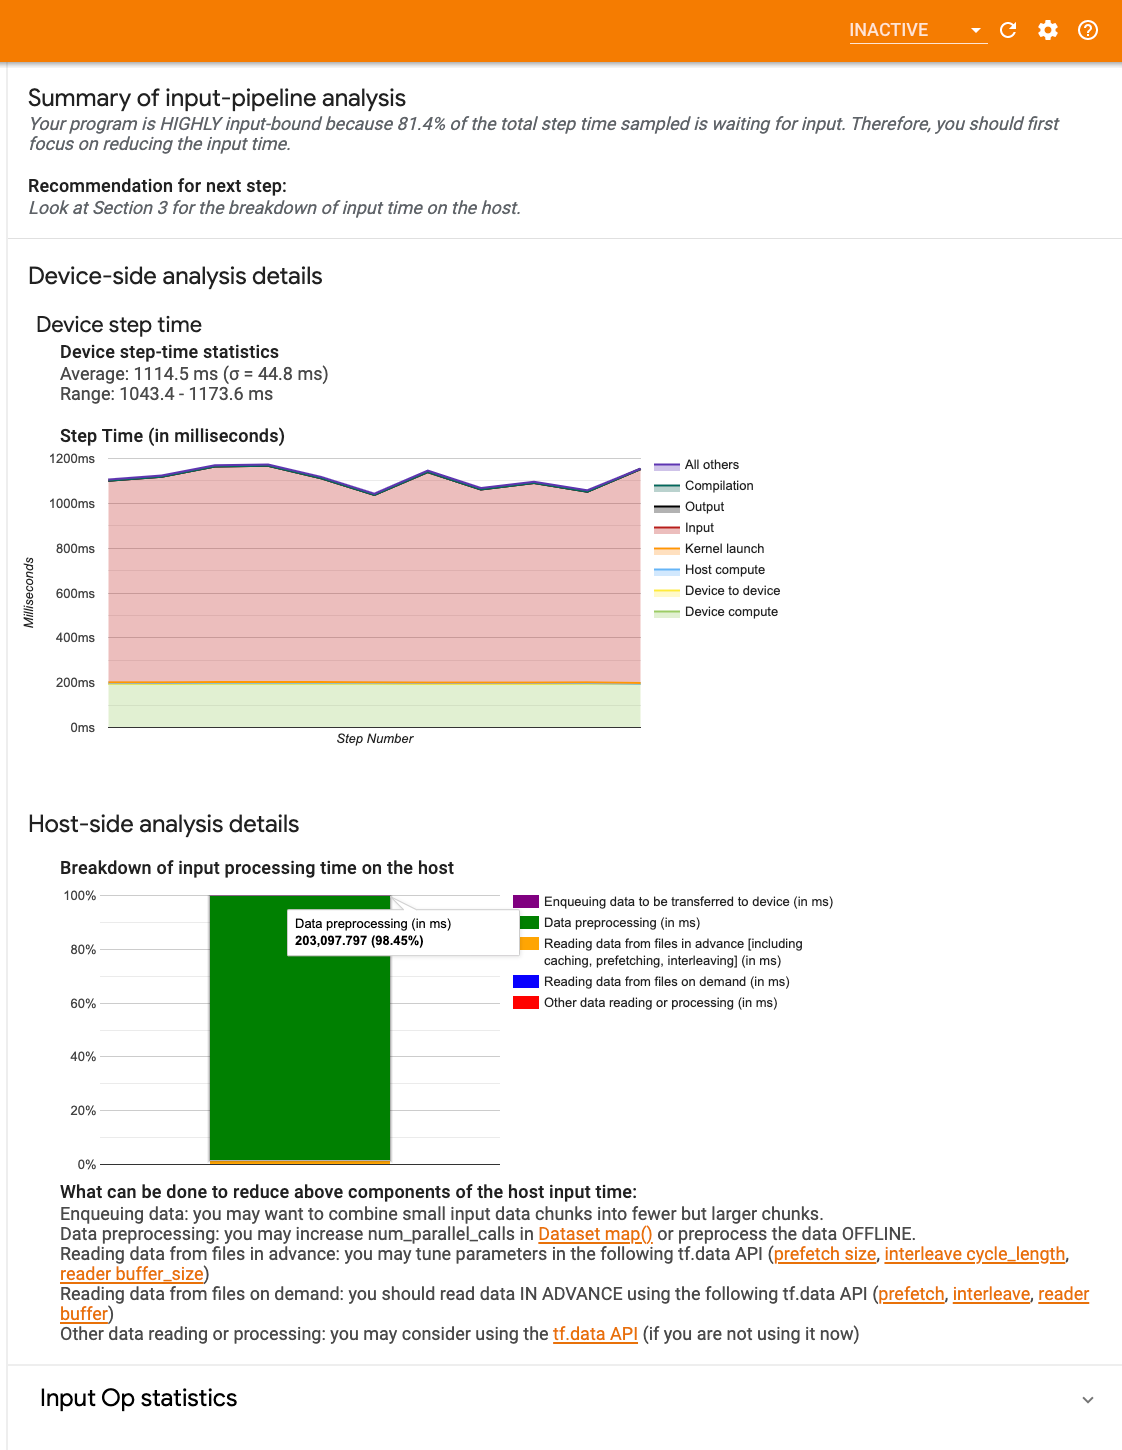

仪表盘包含三个部分:

1.Summary—总结整个输入管道，其中包含应用程序是否受到输入限制的信息，如果有，则是受到多少输入限制

2.设备端分析-显示详细的设备端分析结果，包括设备step-time和每一步跨核心等待输入数据所花费的设备时间范围

3.主机端分析-显示主机端的详细分析，包括主机上输入处理时间的细分

#### 输入管道总结

摘要通过显示等待主机输入所花费的设备时间百分比来报告您的程序是否受到输入限制。如果您正在使用一个已被检测的标准输入管道，该工具将报告在哪里花费了大部分输入处理时间。

#### 设备端分析

设备端分析提供了在设备上花费的时间与在主机上花费的时间以及等待主机输入数据所花费的设备时间。

1.步长时间根据步长编号绘制-在所有采样的步长上显示设备步长时间的图形(以毫秒为单位)。每一步都被分成不同的类别(用不同的颜色)来区分所花费的时间。红色区域对应的是设备处于空闲状态等待主机输入数据的那部分步长时间。绿色区域显示设备实际工作的时间

2.步长时间统计-报告设备步长时间的平均值，标准偏差和范围([最小，最大])

#### 主机端分析

主机端分析报告输入处理时间(在tf.data API ops上花费的时间)的细分类别:

1.按需从文件中读取数据——在不缓存、预取和交叉的情况下从文件中读取数据所花费的时间

2.提前从文件中读取数据——读取文件所花费的时间，包括缓存、预取和交错

3.数据预处理——花费在预处理操作上的时间，例如图像解压缩

4.数据传送到设备前将数据队列化-在将数据传送到设备之前，将数据放入一个输入队列所花费的时间

展开输入Op统计信息，查看各个输入操作的统计信息以及按执行时间细分的类别。

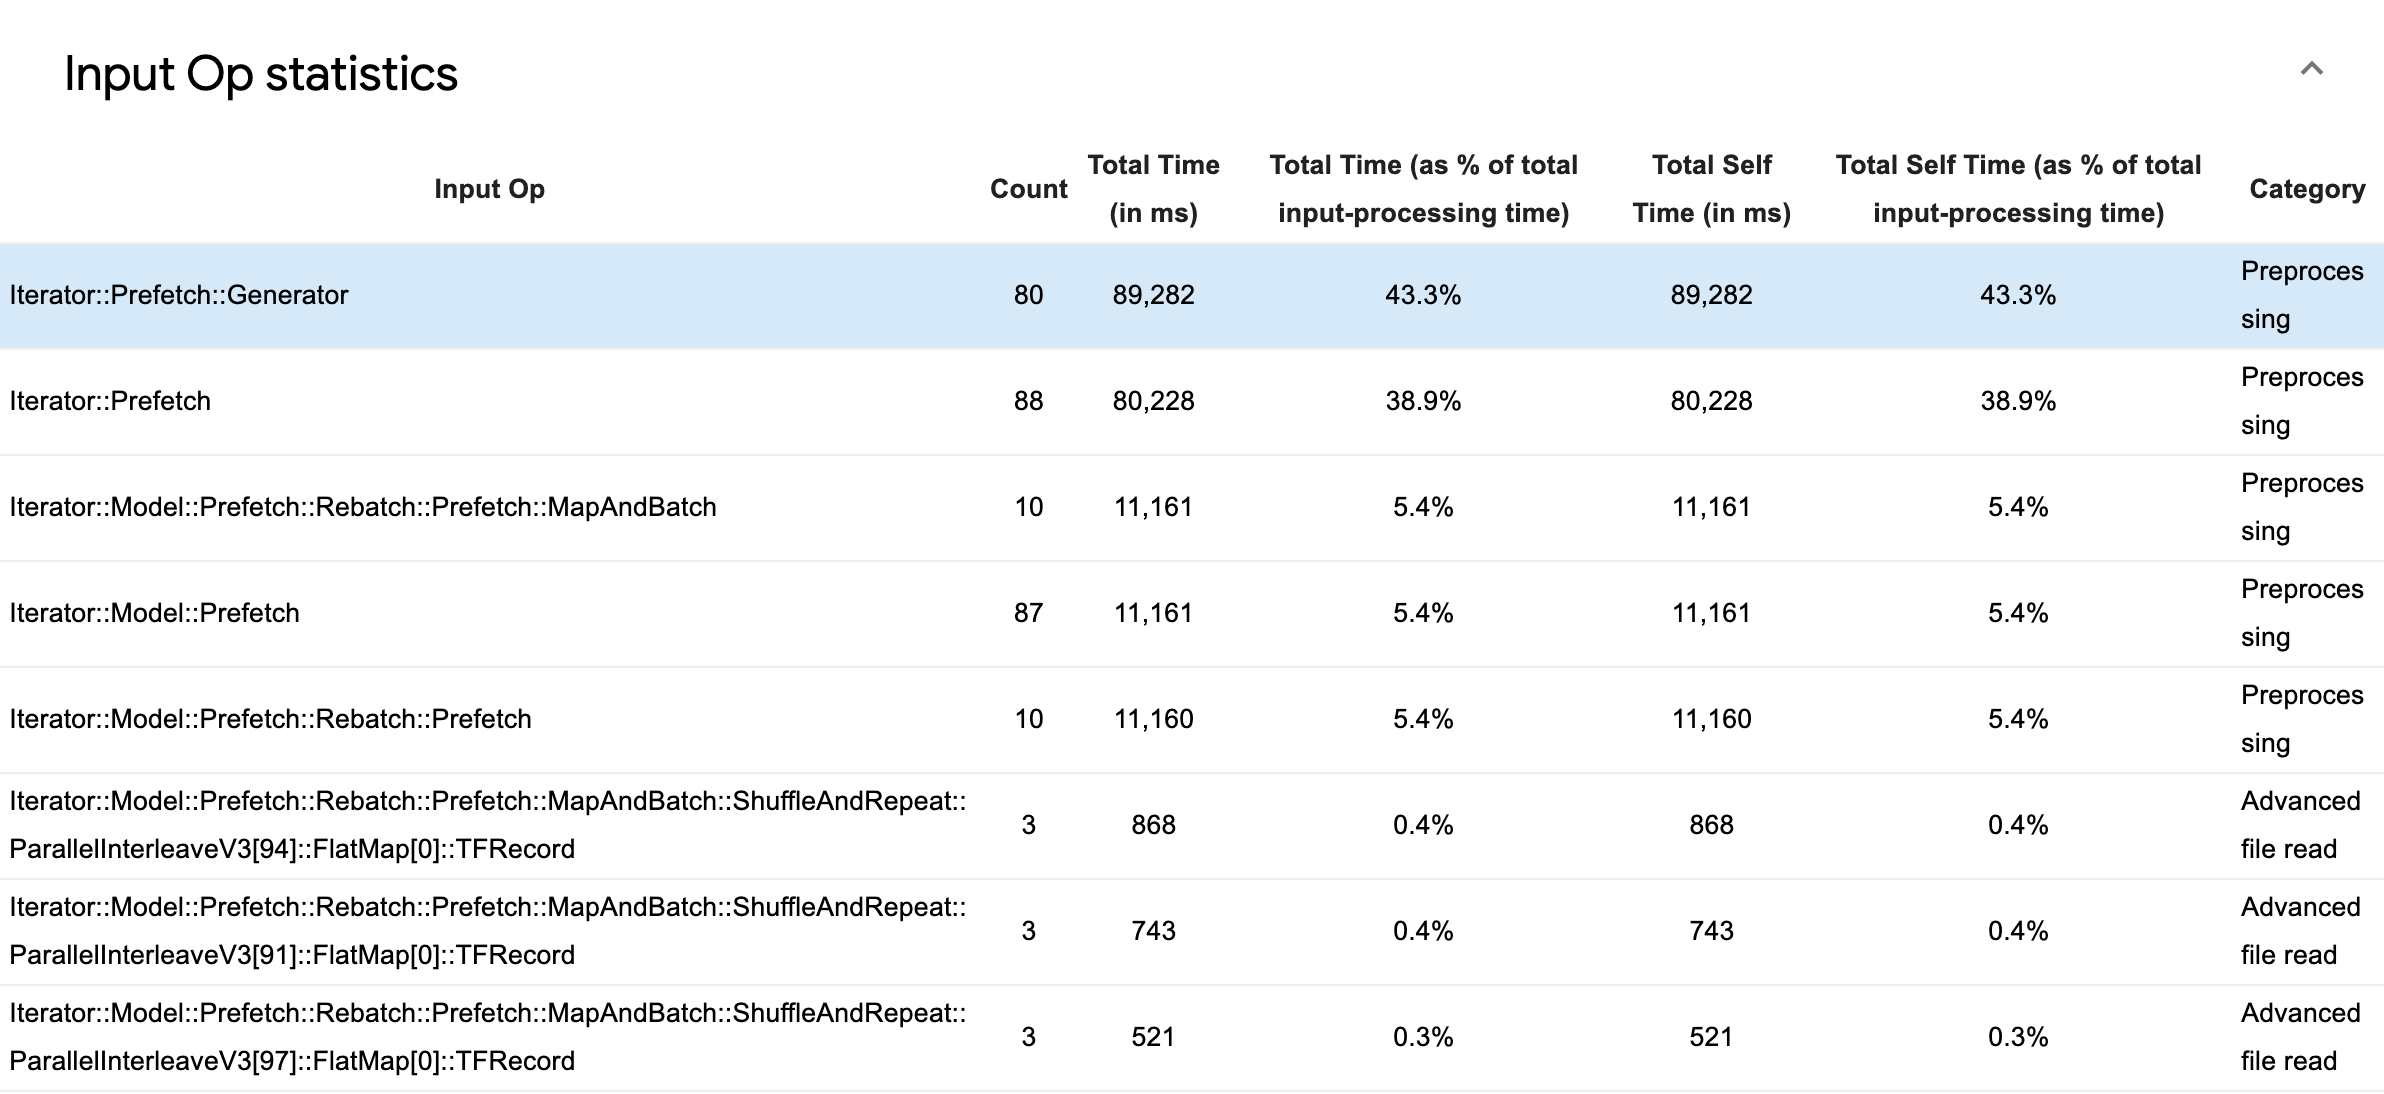

源数据表显示，每个条目包含以下信息:

1.Input Op -显示输入Op的TensorFlow Op名称

2.Count——显示分析期间op执行的实例总数

3.总时间(ms)——显示在每个实例上花费的时间的累计总和

4.总时间% -显示在op上花费的总时间占输入处理总时间的部分

5.总self时间(ms) -显示在每个实例上花费的时间的累计总和。这里的self time度量在函数体中花费的时间，不包括在它调用的函数中花费的时间。

6.总self时间%。将self总时间显示为花费在输入处理上的总时间的一部分

7.类别。显示输入操作的处理类别

### TensorFlow统计数据

TensorFlow Stats工具显示在分析会话期间主机或设备上执行的每个TensorFlow op (op)的性能。

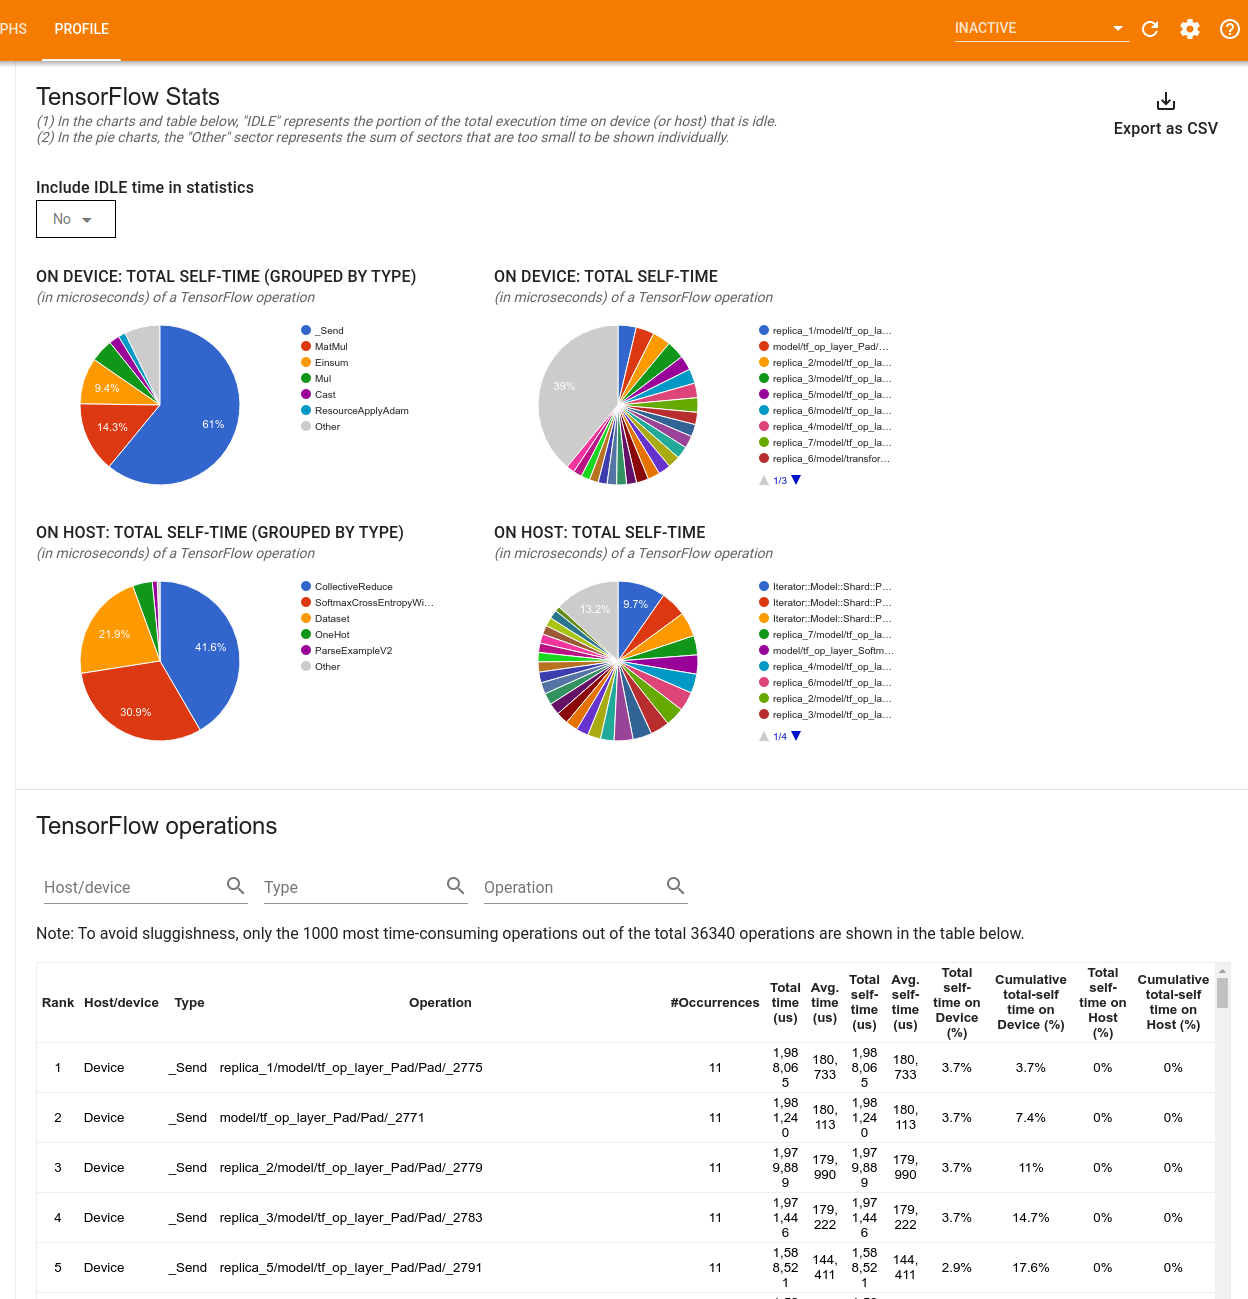

该工具在两个窗格中显示性能信息:

上面的窗格显示多达四个饼图:

1.主机上每个op的自执行（self-execution）时间分布

2.主机上每种op类型的自执行（self-execution）时间分布

3.设备上每个op的自执行（self-execution）时间分布

4.设备上每种op类型的自执行（self-execution）时间分布

下面的窗格显示了一个表，其中报告了关于TensorFlow ops的数据，每个op一行，每种数据类型一列(通过单击列的标题对列进行排序)。单击上窗格右侧的Export as CSV按钮，将该表中的数据导出为CSV文件。

注意:

如果任何ops有子ops:

op的总“累积”时间包括子ops内花费的时间

op的总“self”时间不包括子ops内花费的时间

如果主机上执行op:

op引起的设备上的总自我时间的百分比将为0

在此op之前及包括此op在内的设备上的总自我时间的累积百分比将为0

如果一个op在设备上执行:

此op在主机上产生的总自我时间的百分比将为0

在此op之前及包括此op在内的主机上的总自我时间的累计百分比将为0

您可以选择在饼图和表格中包括或排除空闲时间。

### 跟踪查看器

跟踪查看器显示一个时间轴:

由TensorFlow模型执行的ops的持续时间

系统(主机或设备)的哪一部分执行操作。通常，主机执行输入操作，预处理训练数据并将其传输到设备，而设备执行实际的模型训练

跟踪查看器允许您识别模型中的性能问题，然后采取步骤解决它们。例如，在高层次上，您可以确定是输入还是模型训练占用了大部分时间。向下钻取，您可以确定哪些操作需要花费最长的执行时间。请注意，跟踪查看器被限制为每个设备100万事件。

#### 跟踪查看器接口

当您打开跟踪查看器时，它会显示您最近运行的代码:

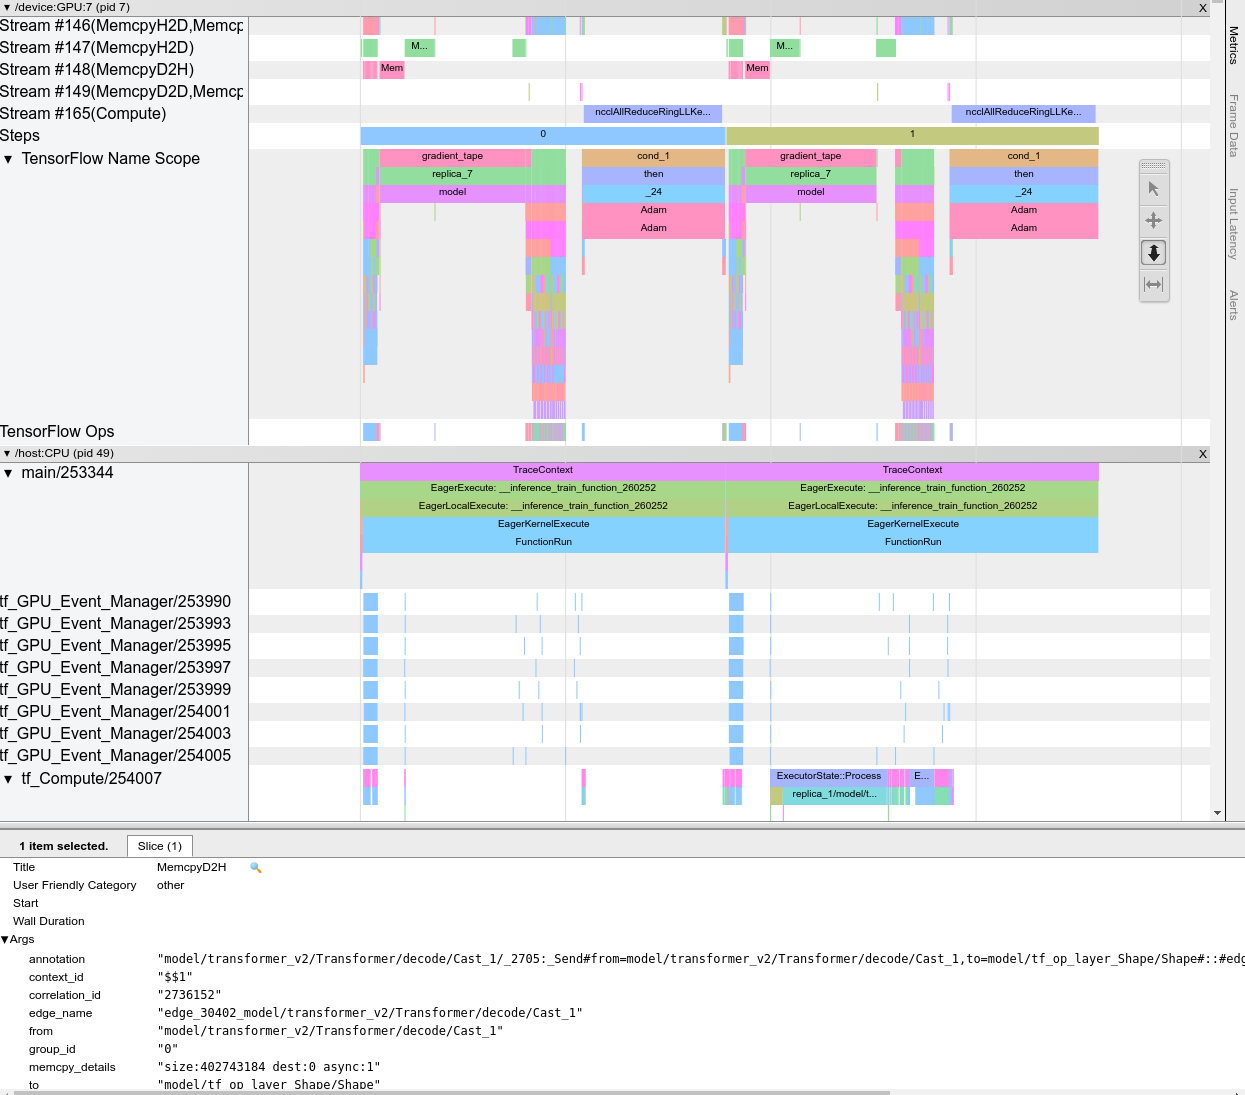

这个界面包含以下主要元素:

1.时间轴窗格-显示设备和主机随时间执行的ops

2.详细信息窗格-显示时间轴窗格中选择的ops的其他信息

时间轴窗格包含以下元素:

1.顶部栏-包含各种辅助控件

2.时间轴-显示相对于跟踪开始处的时间

3.部分和轨道标签-每个部分包含多个轨道，并在左边有一个三角形，你可以点击展开和折叠部分。系统中的每个处理单元都有一个部分

4.工具选择器-包含与跟踪查看器交互的各种工具，如缩放、平移、选择和定时。使用计时工具标记时间间隔。

5.事件——显示执行op的时间或元事件的持续时间，例如训练步骤

##### 部分和跟踪

跟踪查看器包含以下部分:



每个设备节点的一个部分，标记为设备芯片的数量和芯片内的设备节点(例如，/device:GPU:0 (pid 0))。每个设备节点节包含以下轨迹:

  Step-显示在设备上运行的训练步骤的持续时间

  TensorFlow Ops -显示在设备上执行的ops

  XLA Ops -显示设备上运行的XLA操作(如果XLA是使用的编译器)(每个TensorFlow操作被看成一个或几个XLA Ops。XLA编译器将XLA操作转换为运行在设备上的代码)。

在主机CPU上运行的线程的一个部分，标记为“主机线程”。该节为每个CPU线程包含一个track。注意，您可以忽略显示在节标签旁边的信息。

##### 事件

时间轴内的事件以不同的颜色显示;颜色本身并没有特定的含义。



跟踪查看器还可以在TensorFlow程序中显示Python函数调用的跟踪。如果你使用tf.profiler.experimental.start() API，你可以在启动分析时使用名为tuple的ProfilerOptions来启用Python跟踪。或者，如果您使用采样模式进行分析，您可以通过使用Capture Profile对话框中的下拉选项来选择跟踪级别。

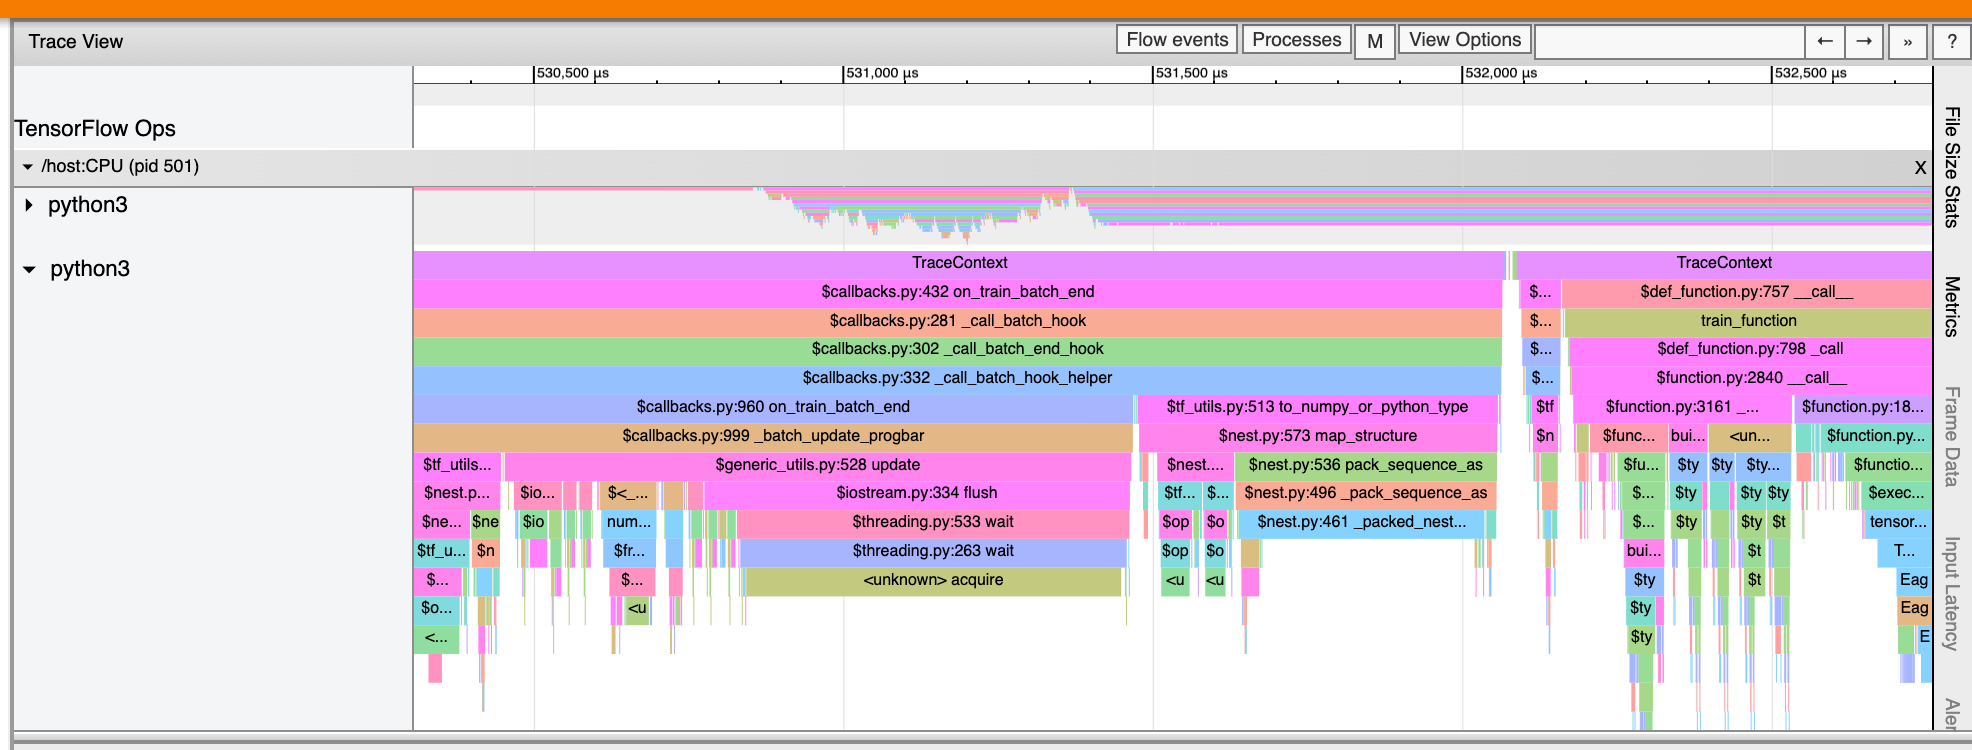

### GPU内核数据

该工具显示了每个GPU加速内核的初始op和性能统计数据。

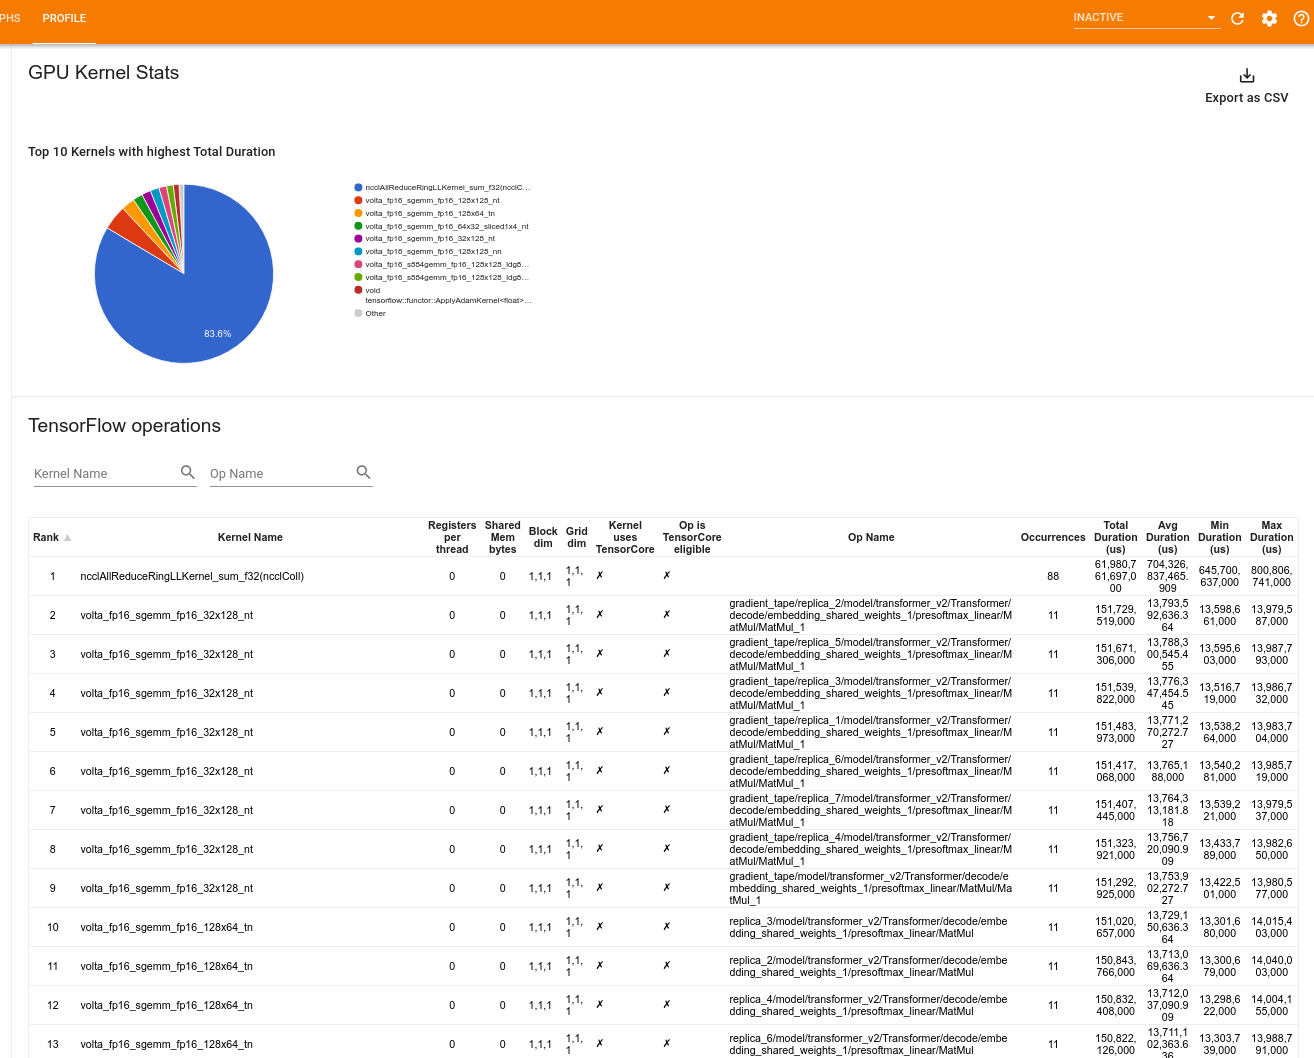

该工具在两个窗格中显示信息:



上面的窗格显示了一个饼图，其中显示了经过的总时间最长的CUDA内核



下面的面板显示了一个表，其中包含每个独特的内核-op对的以下数据:



GPU总运行时间按内核-运算对分组的降序排列的等级

启动内核的名称

内核使用的GPU寄存器的数量

以字节为单位的共享(静态+动态共享)内存的总大小

块尺寸表示为blockDim.x, blockDim.y, blockDim.z

网格尺寸表示为gridDim.x, gridDim.y, gridDim.z

op是否有资格使用TensorCores

内核是否包含TensorCore指令

启动此内核的op的名称

此内核运算对的出现次数

GPU运行总时间(以微秒为单位)

GPU平均运行时间(以微秒为单位)

GPU运行的最短时间(以微秒为单位)

GPU最大运行时间(以微秒为单位)

### 内存配置工具

内存配置工具在分析间隔期间监视设备的内存使用情况。你可以使用这个工具:



1.调试内存不足(OOM)问题，通过准确指出峰值内存使用和相应的内存分配到TensorFlow操作。您还可以调试在运行multi-tenancy推理时可能出现的OOM问题

2.调试内存碎片问题

内存配置文件工具显示数据在三个部分:



1.内存概要总结

2.内存时间线图

3。内存故障表

#### 内存概要总结

这部分显示了TensorFlow程序的内存配置高层概要，如下所示:

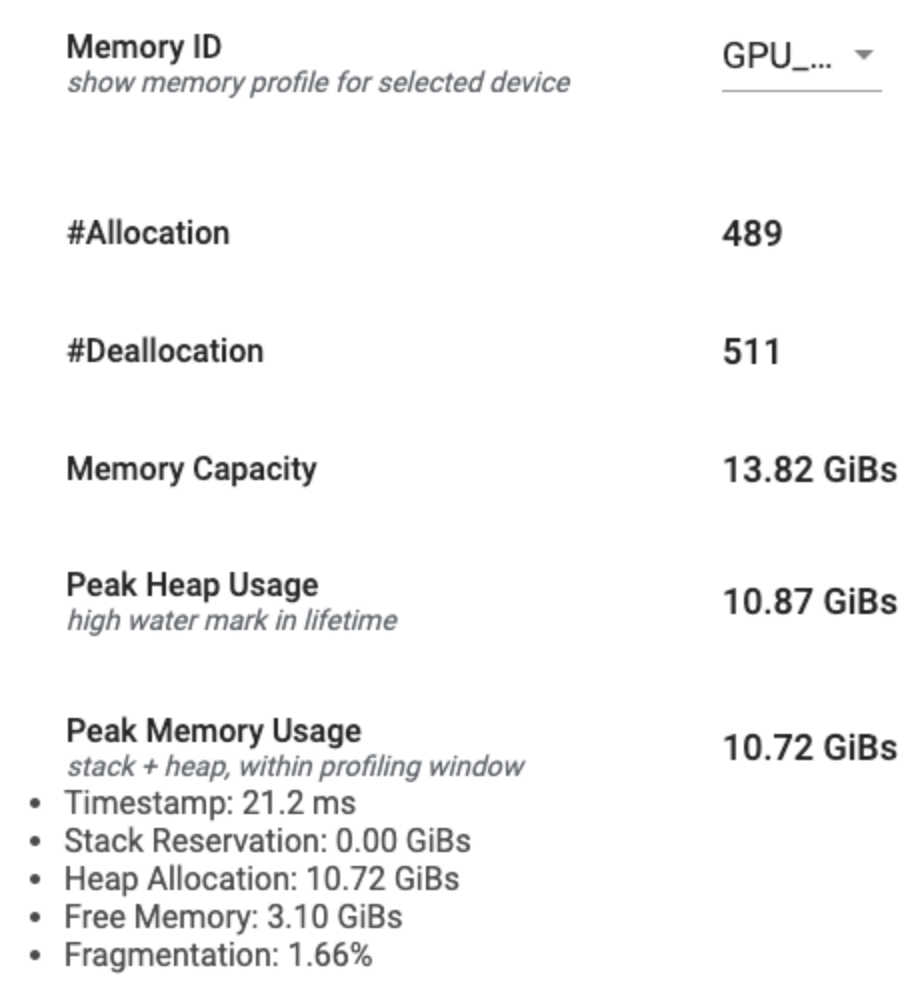

内存配置概要有六个字段:



1.内存ID -下拉列表，列出所有可用的设备内存系统。从下拉菜单中选择要查看的内存系统

2.#Allocation—分析间隔期间分配的内存数量

3.#Deallocation -分析间隔内内存回收的数量

4.内存容量-您所选择的内存系统的总容量(单位为GiBs)

5.堆使用峰值——自模型开始运行以来的内存使用峰值(以GiBs为单位)

6.内存使用峰值-分析间隔内的内存使用峰值(以GiBs为单位)。该字段包含以下子字段:

    a.时间戳——时间轴图上出现内存使用峰值的时间戳

    b.堆栈保留——在堆栈上保留的内存量(以GiBs为单位)

    c.堆分配——堆上分配的内存量(以GiBs为单位)

    d.可用内存——可用内存的数量(以GiBs为单位)。内存容量是堆栈保留、堆分配和空闲内存的总和

    e.碎片-碎片的百分比(越低越好)。它是按百分比计算的(1 -最大可用内存块的大小/总可用内存)

#### 内存时间线图

这部分显示了内存使用情况(以GiBs为单位)和碎片随时间的百分比变化(以ms为单位)。

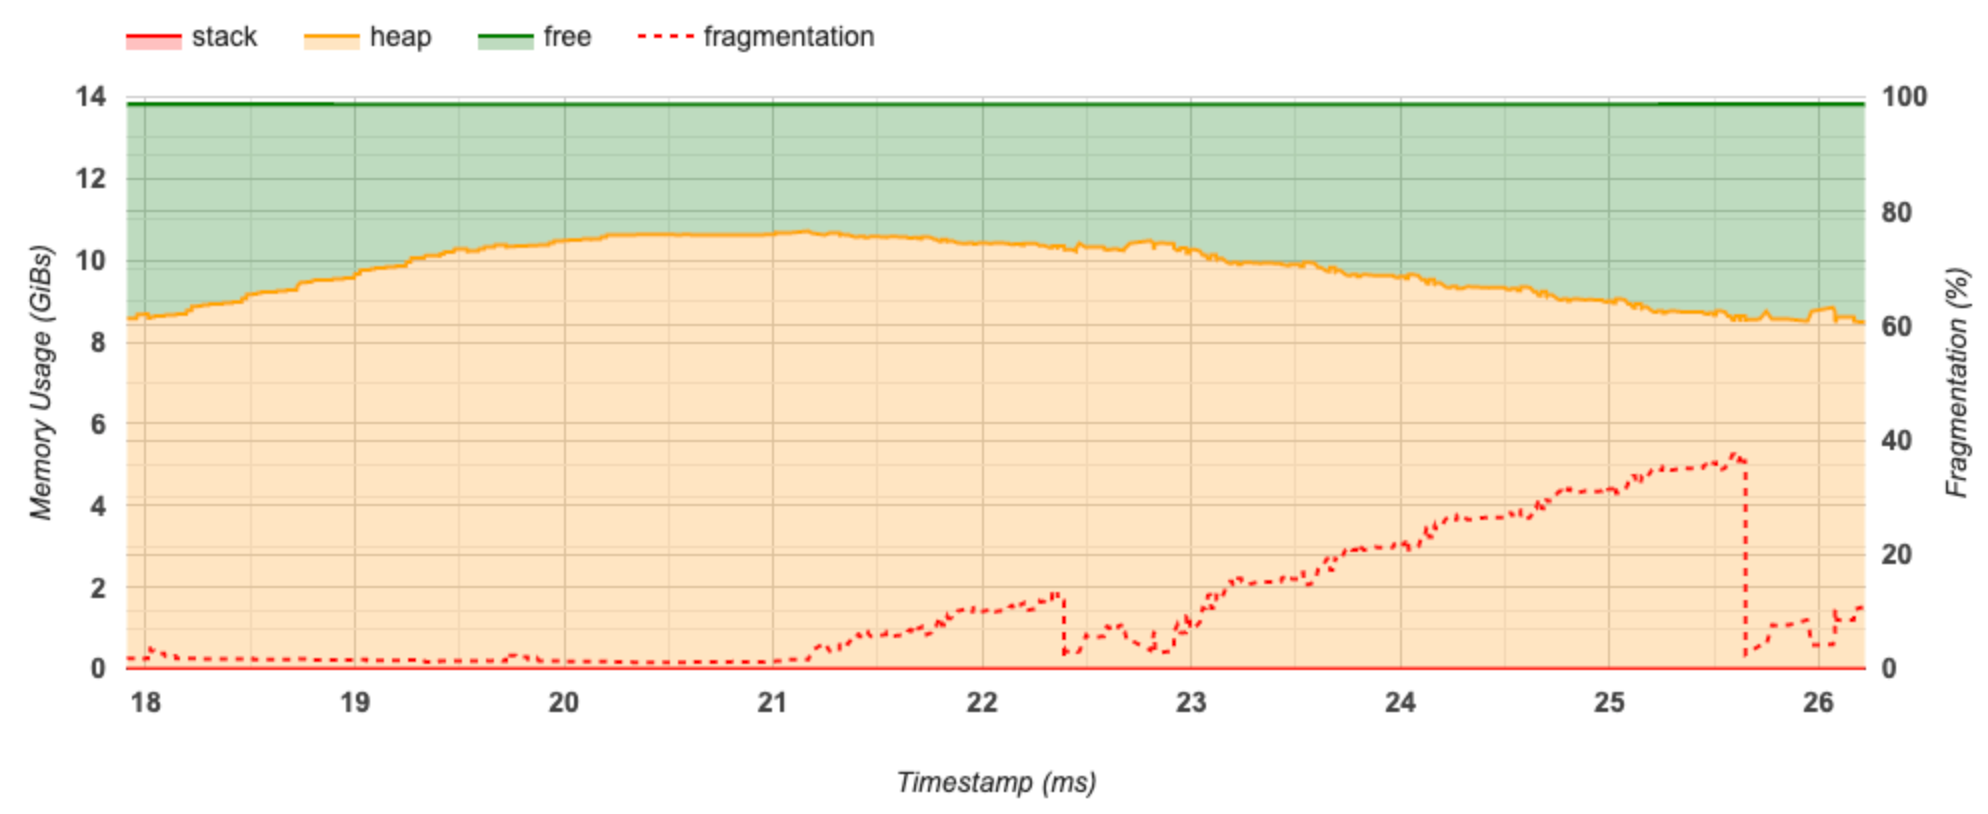

x轴表示分析区间的时间轴(ms)。左边的y轴表示内存使用(单位为GiBs)，右边的y轴表示碎片的百分比。在x轴上的每个时间点，总内存被分解为三种类型:栈(红色)、堆(橙色)和空闲(绿色)。将鼠标悬停在特定的时间戳上，可以查看关于内存分配/释放事件的详细信息，如下所示:

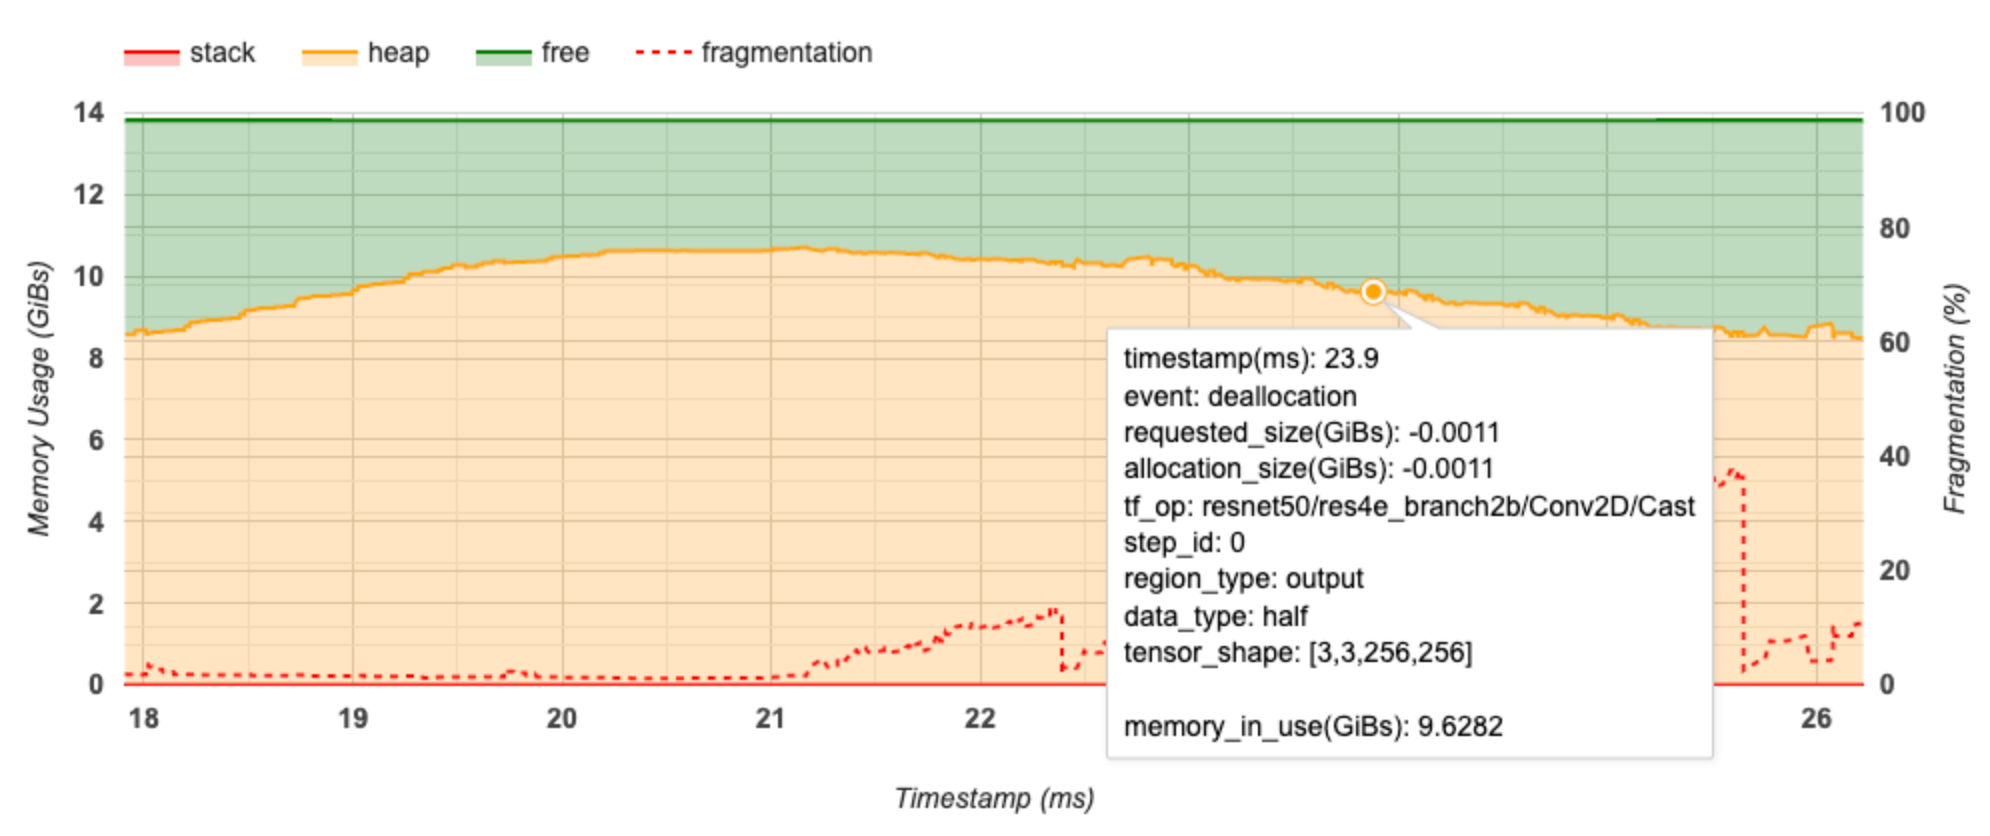

弹出窗口显示以下信息:



    时间戳(ms) -时间轴上选定事件的位置

    事件——事件的类型(分配或回收)

    requested_size(GiBs)——请求的内存量。对于内存释放事件，这将是一个负数

    allocation_size(GiBs)——实际分配的内存量。对于内存释放事件，这将是一个负数

    tf_op - 请求分配/回收的TensorFlow Op

    step_id—发生此事件的training step

    region_type—此分配内存用于的数据实体类型。可能的值是temp(临时值)、output(激活值)和gradient(梯度值)，persist/dynamic(动态值)是weights和constant

    data_type -张量元素类型(例如，8位无符号整数的uint8)

    张量的形状被分配/释放

    memory_in_use(GiBs)——此时正在使用的总内存

#### 内存故障表

下表显示了分析间隔内内存使用峰值时的活动内存分配情况。

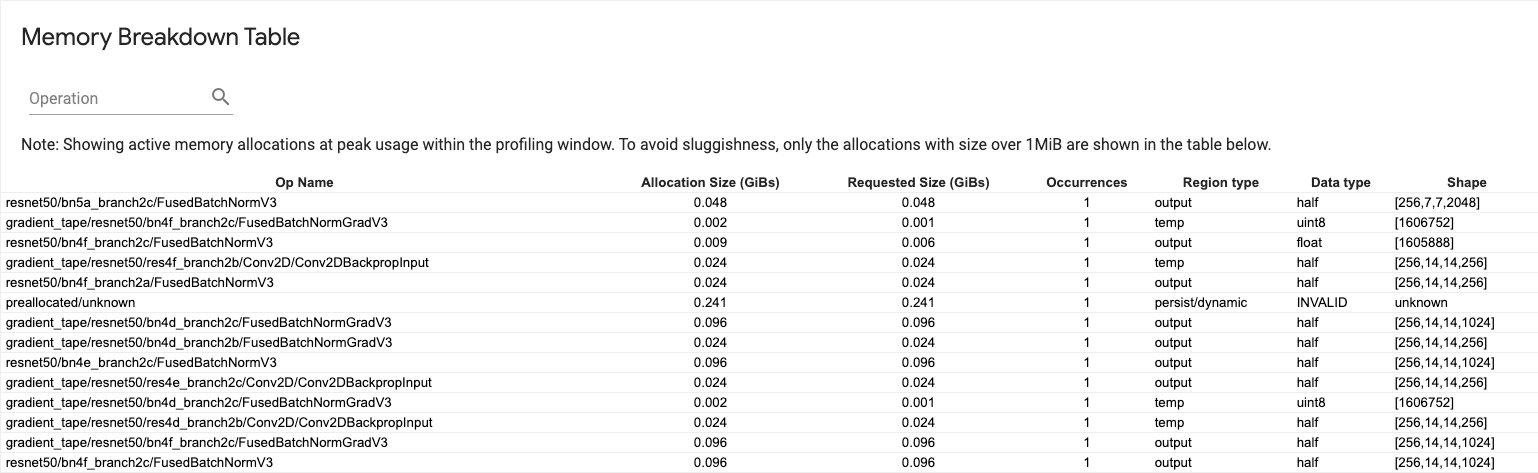

每个TensorFlow Op都有一行，每一行都有以下列:



    Op名称- TensorFlow Op的名称

    分配大小(GiBs) -分配给这个op的总内存量

    请求大小(GiBs) -为这个op请求的内存量

    出现次数——此op的分配数量

    区域类型——分配内存的数据实体类型。可能的值是temp(临时值)、output(激活值)和gradient(梯度值)，persist/dynamic(动态值)是weights和constant

    数据类型——张量元素类型

    形状-分配张量的形状

注意:您可以对表中的任何列进行排序，也可以根据op名称过滤行。

### Pod查看器

Pod查看器工具显示了所有workers的训练步骤的分解。

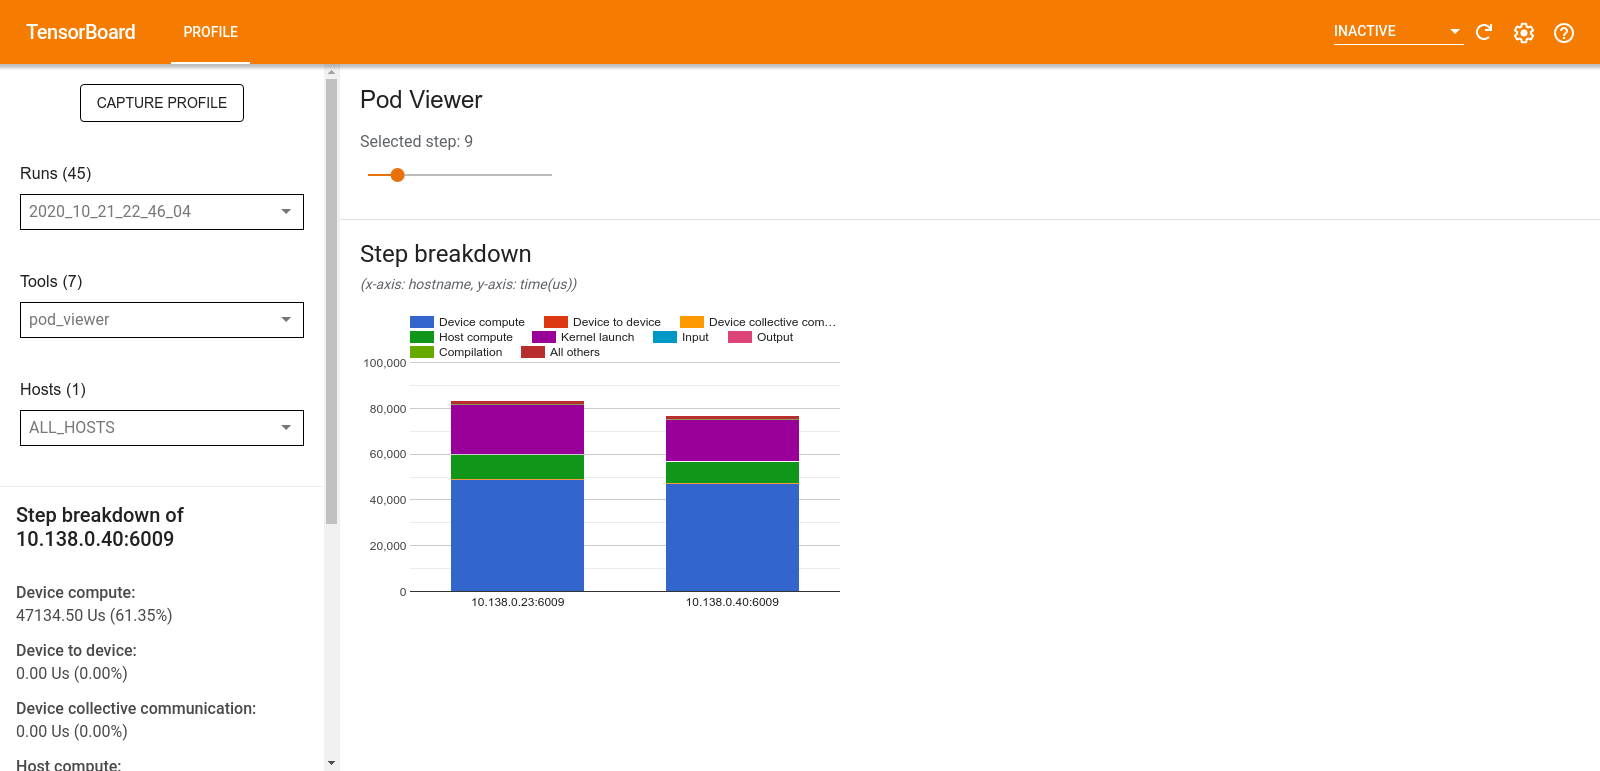

    上窗格有用于选择步数的滑块。

    下部窗格显示堆叠柱形图。这是一个放在另一个之上的视图的高层次的step-time类别分解。每个堆叠的列代表一个唯一的worker。

    当您将鼠标悬停在堆叠的列上时，左侧的卡片会显示有关步骤分解的更多详细信息。

### tf.data瓶颈分析

警告：此工具是实验性的。如果分析结果不合格，请在此报告。

tf.data瓶颈分析自动检测tf.data在程序中输入管道的瓶颈，并提供如何修复它们的建议。它适用于任何使用tf.data不考虑平台（CPU/GPU/TPU）或框架（TensorFlow/JAX）。其分析和建议基于本指南。



它通过以下步骤检测瓶颈：



    1.找到输入最多的主机。

    2.找到执行速度最慢的tf.data输入管道。

    3.从探查器跟踪重建输入管道图。

    4.在输入管道图中找到关键路径。

    5.将关键路径上最慢的转换确定为瓶颈。

UI分为三个部分：性能分析摘要、所有输入管道的摘要和输入管道图。

#### 性能分析总结

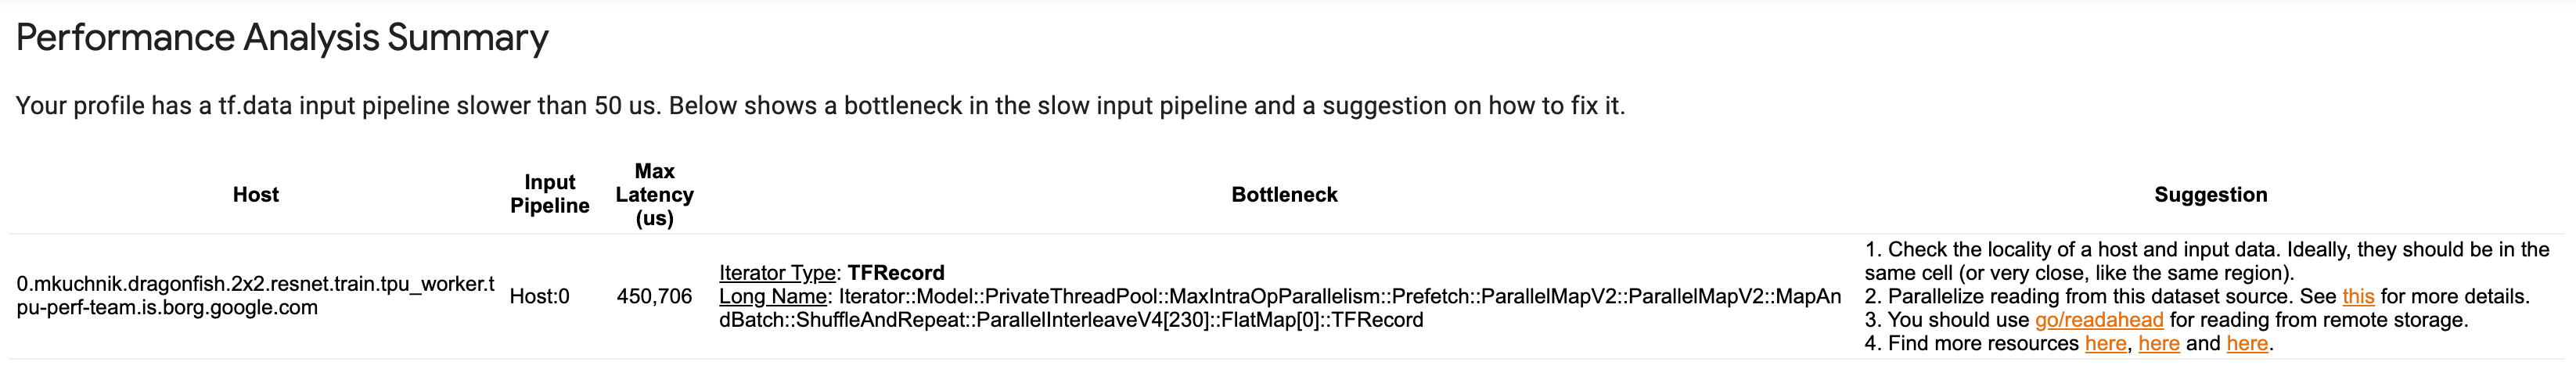

本节提供分析摘要。它告诉我们在配置文件中是否检测到缓慢的tf.data输入管道。如果是这样的话，它将显示输入绑定最多的主机及其最慢的输入管道和最大延迟。最重要的是，它指出输入管道的哪一部分是瓶颈，以及如何解决它。瓶颈信息由迭代器类型及其长名称提供。

##### 如何阅读tf.data迭代器的长名称

长名称格式化为Iterator::<Dataset_1>::...::<Dataset_n>。在长名称中，<Dataset_n>匹配迭代器类型，长名称中的其他数据集表示下游转换。



例如，考虑以下输入管道数据集：

In [ ]:
dataset = tf.data.Dataset.range(10).map(lambda x: x).repeat(2).batch(5)

上述数据集中迭代器的长名称为：

    Iterator Type	Long Name

    Range	Iterator::Batch::Repeat::Map::Range

    Map	Iterator::Batch::Repeat::Map

    Repeat	Iterator::Batch::Repeat

    Batch	Iterator::Batch

### 所有输入管道汇总

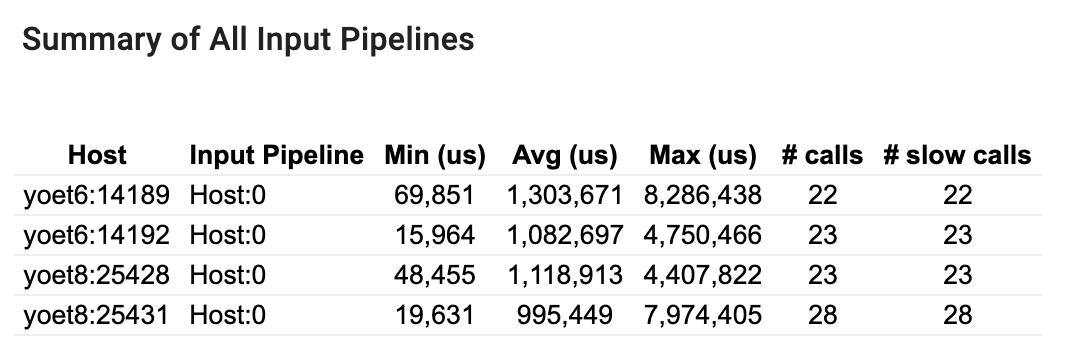

本节提供所有主机上所有输入管道的摘要。通常有一个输入管道。使用分配策略时，有一个主机输入管道运行程序的tf.data代码和多个设备输入管道从主机输入管道检索数据并将其传输到设备。



对于每个输入管道，它显示其执行时间的统计信息。如果通话（call)时间超过50μs，则视为通话（call)慢。

### 输入管道图

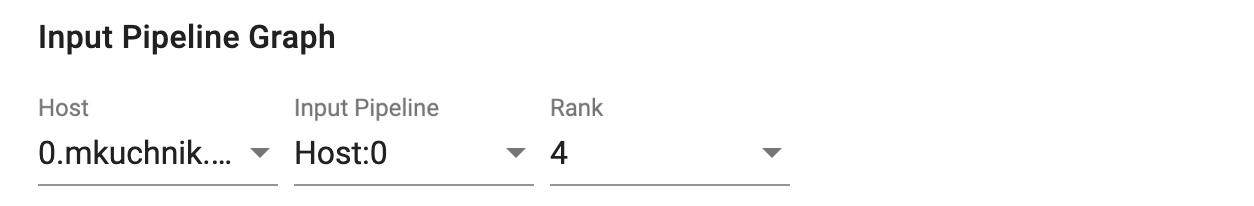

本节显示了包含执行时间信息的输入管道图。您可以使用“主机”和“输入管道”来选择要查看的主机和输入管道。输入管道的执行按执行时间的降序排序，您可以使用“Rank”来选择。

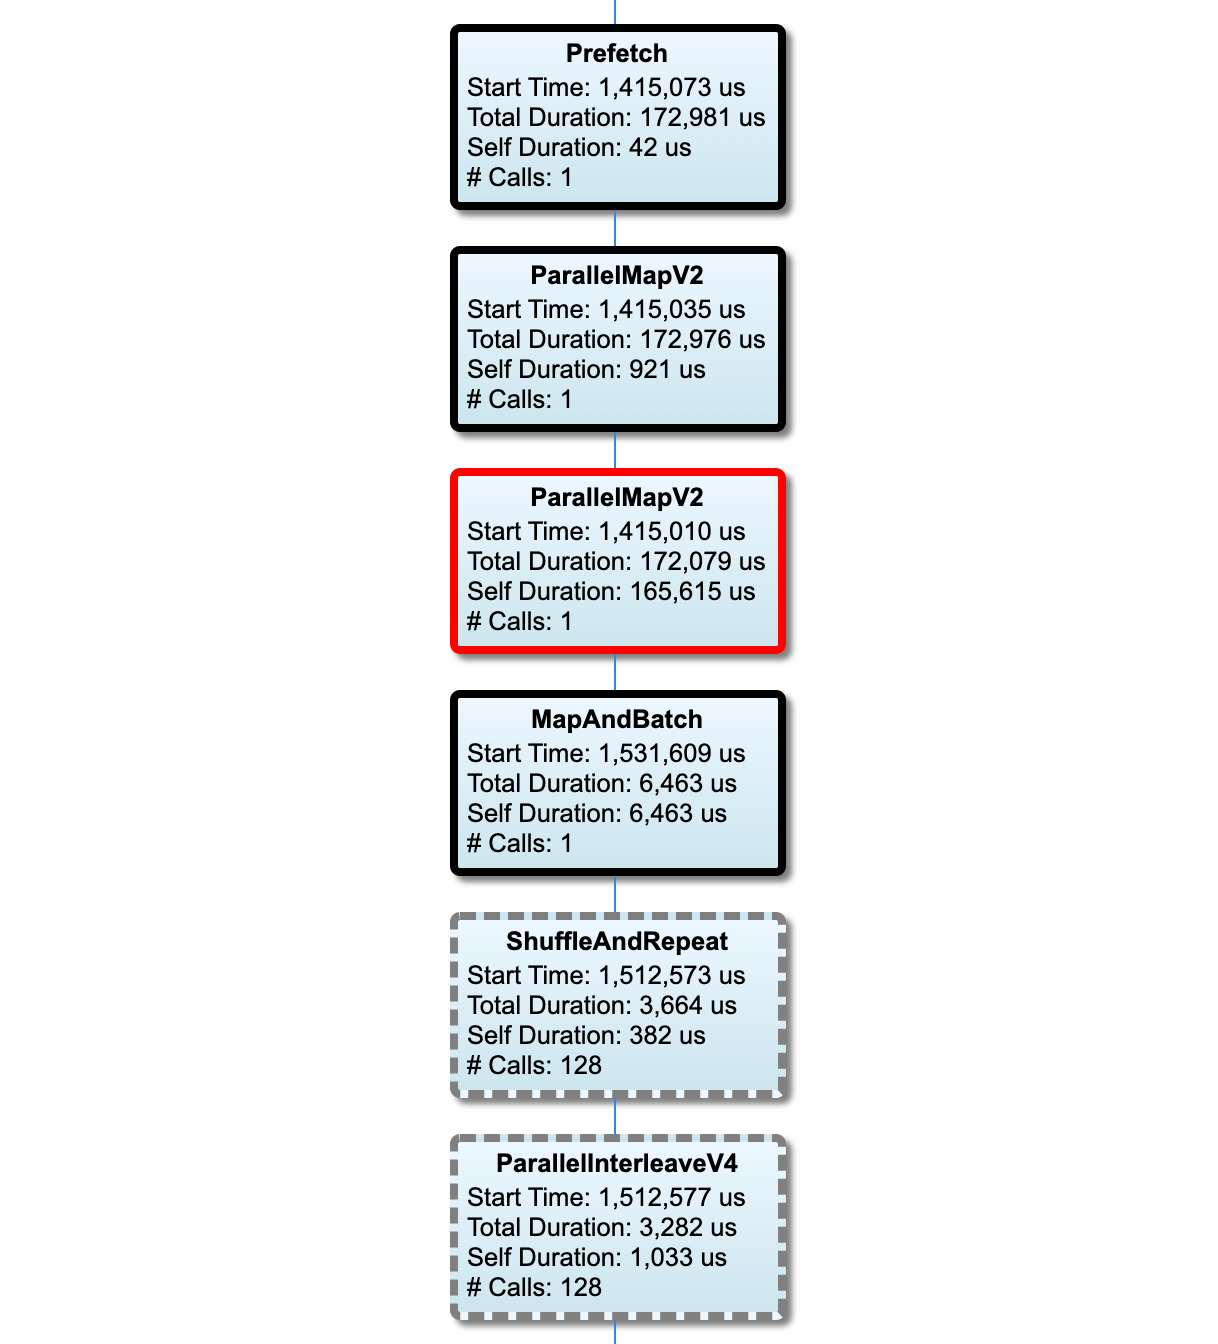

关键路径上的节点有粗体轮廓。瓶颈节点是关键路径上self时间最长的节点，有一个红色的轮廓。其他非关键节点具有灰色虚线轮廓。



在每个节点中，“开始时间”表示执行的开始时间。例如，如果输入管道中存在批处理，则可以多次执行同一节点。如果执行多次，则为第一次执行的开始时间。



“总持续时间”是执行的墙时间(wall time)。如果执行多次，则为所有执行的墙时间之和。



“Self Time”是指没有与其直接子节点重叠的时间的“总时间”。



“# Calls”是执行输入管道的次数。

## 收集性能数据

TensorFlow Profiler收集TensorFlow模型的主机活动和GPU跟踪。您可以将探查器配置为通过编程模式或采样模式收集性能数据。

### 配置API

您可以使用以下API来执行分析。



    使用TensorBoard Keras Callback (tf.keras.callbacks.TensorBoard)的编程模式

In [ ]:
# Profile from batches 10 to 15
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                             profile_batch='10, 15')

# Train the model and use the TensorBoard Keras callback to collect
# performance profiling data
model.fit(train_data,
          steps_per_epoch=20,
          epochs=5,
          callbacks=[tb_callback])

使用tf.profiler 函数 API的编程模式

In [ ]:
tf.profiler.experimental.start('logdir')
# Train the model here
tf.profiler.experimental.stop()

使用上下文管理器的编程模式

In [ ]:
with tf.profiler.experimental.Profile('logdir'):
    # Train the model here
    pass

注意：运行Profiler 太长时间会导致内存不足。建议一次分析不超过10个步骤。避免分析前几个批处理，以避免由于初始化开销而导致的不准确。

采样模式-通过TensorFlow模型使用tf.profiler.experimental.server.start() 运行启动gRPC服务器。启动gRPC服务器并运行您的模型之后，您可以通过TensorBoard profile插件中的Capture Profile 按钮来获取概要文件。如果TensorBoard实例尚未运行，请使用上面的Install profiler部分中的脚本启动TensorBoard实例。



例如，

In [ ]:
# Start a profiler server before your model runs.
tf.profiler.experimental.server.start(6009)
# (Model code goes here).
#  Send a request to the profiler server to collect a trace of your model.
tf.profiler.experimental.client.trace('grpc://localhost:6009',
                                      'gs://your_tb_logdir', 2000)

分析多个工作线程的示例：

In [ ]:
# E.g. your worker IP addresses are 10.0.0.2, 10.0.0.3, 10.0.0.4, and you
# would like to profile for a duration of 2 seconds.
tf.profiler.experimental.client.trace(
    'grpc://10.0.0.2:8466,grpc://10.0.0.3:8466,grpc://10.0.0.4:8466',
    'gs://your_tb_logdir',
    2000)

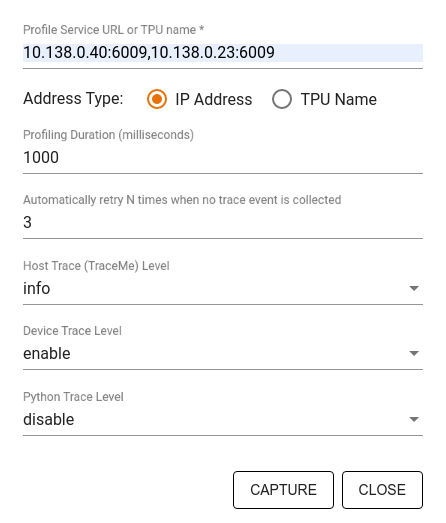

使用“Capture Profile”对话框可以指定：



    以逗号分隔的配置文件服务URL或TPU名称的列表。

    分析持续时间。

    设备、主机和Python函数调用跟踪的级别。

    如果一开始不成功，您希望Profiler重试获取配置文件的次数。

#### 分析自定义训练循环

要在TensorFlow代码中评测自定义训练循环，请使用tf.profiler.experimental.Trace  API来标记Profiler的步骤边界。name参数用作步骤名称的前缀，step_num 关键词参数附加在步骤名称中，_r 关键词参数使Profiler将此跟踪事件作为步骤事件进行处理。



例如，

In [ ]:
for step in range(NUM_STEPS):
    with tf.profiler.experimental.Trace('train', step_num=step, _r=1):
        train_data = next(dataset)
        train_step(train_data)

这将启用Profiler基于步骤的性能分析，并使步骤事件显示在跟踪查看器中。



确保在tf.profiler.experimental.Trace上下文中包括了数据集迭代器以准确分析输入管道。



下面的代码片段是反模式：

警告：这将导致对输入管道的分析不准确。

In [ ]:
for step, train_data in enumerate(dataset):
    with tf.profiler.experimental.Trace('train', step_num=step, _r=1):
        train_step(train_data)

#### 分析用例

profiler沿着四个不同的轴覆盖了许多用例。其中一些组合目前受到支持，其他组合将在将来添加。一些用例包括：



    本地和远程评测：这是两种常见的设置评测环境的方法。在本地评测中， profiling API在运行模型的计算机上被一同调用，例如，带有gpu的本地工作站。在远程评测中，profiling API调用与模型运行在不同的计算机上，例如，Cloud TPU.

    分析多个worker：在使用TensorFlow的分布式培训功能时，可以评测多台机器。

    硬件平台：Profile CPUs, GPUs, and TPUs.

下表简要介绍了TensorFlow中的各种profiling API支持上述哪些用例：

Profiling API	Local	Remote	Multiple workers	Hardware Platforms

TensorBoard Keras Callback	Supported	Not Supported	Not Supported	CPU, GPU

tf.profiler.experimental start/stop API	Supported	Not Supported	Not Supported	CPU, GPU

tf.profiler.experimental client.trace API	Supported	Supported	Supported	CPU, GPU, TPU

Context manager API	Supported	Not supported	Not Supported	CPU, GPU

## 最佳模型性能的最佳实践

使用以下适用于TensorFlow模型的建议，以获得最佳性能。



通常，在设备上执行所有转换，并确保在您的平台上使用最新的兼容库版本，如cuDNN和“英特尔MKL”。

### 优化输入数据管道

有效的数据输入管道可以通过减少设备空闲时间来显著提高模型执行的速度。请考虑合并以下详细介绍的最佳实践，以提高数据输入管道的效率：



    1.预取数据

    2.并行化数据提取

    3.并行化数据转换

    4.在内存中缓存数据

    5.矢量化用户定义函数

    6.应用转换时减少内存使用

另外，尝试使用合成数据运行模型，以检查输入管道是否是性能瓶颈。

### 提高设备性能

    增加小批量（在训练循环的一次迭代中每个设备使用的训练样本数）训练

    使用TF Stats了解设备上操作的运行效率

    使用 tf.function 执行计算并可选地启用experimental_compile标志

    最小化步骤之间的主机Python操作并减少回调。每隔几步而不是每一步都计算度量指标

    使设备计算单元保持忙碌

    将数据并行发送到多个设备

    优化数据布局，优先选择频道（例如NCHW比NHWC）。某些GPU，如NVIDIA®V100，在NHWC数据布局下表现更佳。

    考虑使用16位数字表示，例如fp16，由IEEE指定的半精度浮点格式或Brain floating-point bfloat16格式

    考虑使用Keras mixed precision API

    在gpu上进行训练时，请使用TensorCore。当精度为fp16且输入/输出维度可被8或16整除时，GPU内核使用TensorCore（对于int8）

### 额外资源

    请参阅端到端TensorBoard profiler教程，以实现本指南中的建议。

    观看TensorFlow Dev Summit 2020的TF 2演讲中的性能分析。

### 已知限制

#### 在TensorFlow 2.2和TensorFlow 2.3上评测多个GPU

TensorFlow 2.2和2.3仅支持单主机系统的多GPU评测；不支持多主机系统的多GPU评测。要评测multi-worker GPU配置，必须独立分析每个工作线程。在TensorFlow 2.4中，可以使用 tf.profiler.experimental.trace API.



要评测多个GPU，需要CUDA®Toolkit 10.2或更高版本。由于TensorFlow 2.2和2.3仅支持CUDA®Toolkit 10.1版本，请创建指向libcudart.so.10.1 和 libcupti.so.10.1.的符号链接。

In [ ]:
sudo ln -s /usr/local/cuda/lib64/libcudart.so.10.2 /usr/local/cuda/lib64/libcudart.so.10.1
sudo ln -s /usr/local/cuda/extras/CUPTI/lib64/libcupti.so.10.2 /usr/local/cuda/extras/CUPTI/lib64/libcupti.so.10.1